In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory
import tensorflow_addons as tfa

In [2]:
TRAIN_DIR = '../../../data/cell_type/training'
TEST_DIR = '../../../data/cell_type/testing'
VAL_DIR = '../../../data/cell_type/validation'
# INPUT_WIDTH = 27
# INPUT_HEIGHT = 27

BATCH_SIZE = 64
IMG_SIZE = (32, 32)


train_dataset = image_dataset_from_directory(TRAIN_DIR,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             interpolation='nearest',
                                             label_mode='categorical'
                                            )

validation_dataset = image_dataset_from_directory(VAL_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
                                                  label_mode='categorical'
                                            )

test_dataset = image_dataset_from_directory(TEST_DIR,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE,
                                                  interpolation='nearest',
                                                  label_mode='categorical'
                                            )

Found 7915 files belonging to 4 classes.
Found 990 files belonging to 4 classes.
Found 991 files belonging to 4 classes.


In [3]:
def get_class_name(class_num):
    if class_num == 0:
        return 'fibroblast'
    elif class_num == 1:
        return 'inflammatory'
    elif class_num == 2:
        return 'epithelial'
    else:
        return 'others'

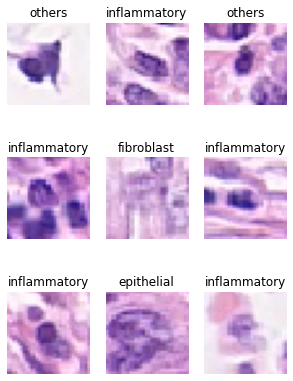

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(5, 7))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(get_class_name(tf.where(tf.equal(labels[i], 1)).numpy()[0][0]))
        plt.axis("off")

In [5]:
train_dataset.class_names

['0', '1', '2', '3']

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

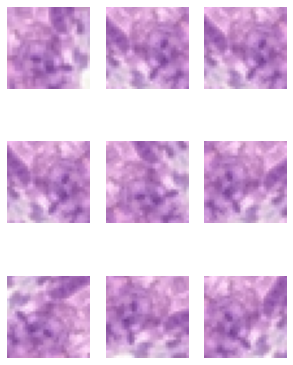

In [8]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(5, 7))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [11]:
# Create the base model from the MobileNetV2 model without loading pretrained-weights
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights=None)

In [12]:
# image_batch, label_batch = next(iter(train_dataset))
# feature_batch = base_model(image_batch)
# print(feature_batch.shape)

In [13]:
for layer in base_model.layers:
    layer.trainable = True

In [14]:
# base_model.trainable = False

In [15]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 16, 16, 32)   0           bn_Conv1[0][0]                   
________________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
# feature_batch_average = global_average_layer(feature_batch)
# print(feature_batch_average.shape)

In [17]:
prediction_layer = tf.keras.layers.Dense(4)
# prediction_batch = prediction_layer(feature_batch_average)
# print(prediction_batch.shape)

In [18]:
inputs = tf.keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score ,precision_m, recall_m])

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [21]:
len(model.trainable_variables)

158

In [22]:
epochs = 500

loss0, accuracy0, f1_0, precision0, recall0 = model.evaluate(validation_dataset)

16/16 [==============================] - 3s 12ms/step - loss: 1.5416 - accuracy: 0.2919 - f1_score: 0.3612 - precision_m: 0.2810 - recall_m: 0.5060


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 1.54
initial accuracy: 0.29


In [24]:
import time
start_time = time.time()

In [25]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/500
124/124 [==============================] - 6s 21ms/step - loss: 1.4520 - accuracy: 0.3790 - f1_score: 0.4151 - precision_m: 0.3218 - recall_m: 0.5858 - val_loss: 1.3293 - val_accuracy: 0.4232 - val_f1_score: 0.4470 - val_precision_m: 0.3474 - val_recall_m: 0.6275
Epoch 2/500
124/124 [==============================] - 2s 18ms/step - loss: 1.3885 - accuracy: 0.4068 - f1_score: 0.4357 - precision_m: 0.3388 - recall_m: 0.6114 - val_loss: 1.2965 - val_accuracy: 0.4333 - val_f1_score: 0.4494 - val_precision_m: 0.3516 - val_recall_m: 0.6234
Epoch 3/500
124/124 [==============================] - 2s 16ms/step - loss: 1.3432 - accuracy: 0.4226 - f1_score: 0.4463 - precision_m: 0.3462 - recall_m: 0.6287 - val_loss: 1.2491 - val_accuracy: 0.4475 - val_f1_score: 0.4790 - val_precision_m: 0.3729 - val_recall_m: 0.6704
Epoch 4/500
124/124 [==============================] - 2s 16ms/step - loss: 1.3138 - accuracy: 0.4406 - f1_score: 0.4540 - precision_m: 0.3537 - recall_m: 0.6349 - val_loss

Epoch 31/500
124/124 [==============================] - 2s 15ms/step - loss: 0.7568 - accuracy: 0.7013 - f1_score: 0.6322 - precision_m: 0.4996 - recall_m: 0.8621 - val_loss: 0.7502 - val_accuracy: 0.6909 - val_f1_score: 0.6356 - val_precision_m: 0.5075 - val_recall_m: 0.8518
Epoch 32/500
124/124 [==============================] - 2s 16ms/step - loss: 0.7486 - accuracy: 0.7070 - f1_score: 0.6308 - precision_m: 0.4972 - recall_m: 0.8637 - val_loss: 0.7374 - val_accuracy: 0.6970 - val_f1_score: 0.6336 - val_precision_m: 0.4983 - val_recall_m: 0.8706
Epoch 33/500
124/124 [==============================] - 2s 16ms/step - loss: 0.7358 - accuracy: 0.7094 - f1_score: 0.6317 - precision_m: 0.4953 - recall_m: 0.8726 - val_loss: 0.7333 - val_accuracy: 0.7061 - val_f1_score: 0.6335 - val_precision_m: 0.4983 - val_recall_m: 0.8704
Epoch 34/500
124/124 [==============================] - 2s 16ms/step - loss: 0.7349 - accuracy: 0.7147 - f1_score: 0.6271 - precision_m: 0.4905 - recall_m: 0.8701 - val_

Epoch 61/500
124/124 [==============================] - 2s 15ms/step - loss: 0.6389 - accuracy: 0.7533 - f1_score: 0.6569 - precision_m: 0.5185 - recall_m: 0.8971 - val_loss: 0.6474 - val_accuracy: 0.7566 - val_f1_score: 0.6644 - val_precision_m: 0.5265 - val_recall_m: 0.9012
Epoch 62/500
124/124 [==============================] - 2s 15ms/step - loss: 0.6359 - accuracy: 0.7493 - f1_score: 0.6621 - precision_m: 0.5251 - recall_m: 0.8968 - val_loss: 0.6467 - val_accuracy: 0.7475 - val_f1_score: 0.6720 - val_precision_m: 0.5350 - val_recall_m: 0.9042
Epoch 63/500
124/124 [==============================] - 2s 16ms/step - loss: 0.6367 - accuracy: 0.7535 - f1_score: 0.6643 - precision_m: 0.5281 - recall_m: 0.8966 - val_loss: 0.6231 - val_accuracy: 0.7455 - val_f1_score: 0.6648 - val_precision_m: 0.5247 - val_recall_m: 0.9074
Epoch 64/500
124/124 [==============================] - 2s 15ms/step - loss: 0.6264 - accuracy: 0.7534 - f1_score: 0.6669 - precision_m: 0.5303 - recall_m: 0.8992 - val_

Epoch 91/500
124/124 [==============================] - 2s 16ms/step - loss: 0.5386 - accuracy: 0.7934 - f1_score: 0.6843 - precision_m: 0.5448 - recall_m: 0.9211 - val_loss: 0.5669 - val_accuracy: 0.7808 - val_f1_score: 0.6932 - val_precision_m: 0.5531 - val_recall_m: 0.9287
Epoch 92/500
124/124 [==============================] - 2s 15ms/step - loss: 0.5391 - accuracy: 0.7958 - f1_score: 0.6842 - precision_m: 0.5441 - recall_m: 0.9222 - val_loss: 0.5458 - val_accuracy: 0.7828 - val_f1_score: 0.6966 - val_precision_m: 0.5596 - val_recall_m: 0.9229
Epoch 93/500
124/124 [==============================] - 2s 15ms/step - loss: 0.5362 - accuracy: 0.7939 - f1_score: 0.6919 - precision_m: 0.5527 - recall_m: 0.9257 - val_loss: 0.5642 - val_accuracy: 0.7788 - val_f1_score: 0.7022 - val_precision_m: 0.5641 - val_recall_m: 0.9307
Epoch 94/500
124/124 [==============================] - 2s 15ms/step - loss: 0.5321 - accuracy: 0.7980 - f1_score: 0.6950 - precision_m: 0.5557 - recall_m: 0.9284 - val_

124/124 [==============================] - 2s 15ms/step - loss: 0.4688 - accuracy: 0.8201 - f1_score: 0.7019 - precision_m: 0.5605 - recall_m: 0.9397 - val_loss: 0.5417 - val_accuracy: 0.7879 - val_f1_score: 0.6992 - val_precision_m: 0.5611 - val_recall_m: 0.9283
Epoch 121/500
124/124 [==============================] - 2s 16ms/step - loss: 0.4557 - accuracy: 0.8249 - f1_score: 0.6980 - precision_m: 0.5548 - recall_m: 0.9418 - val_loss: 0.5242 - val_accuracy: 0.7929 - val_f1_score: 0.6844 - val_precision_m: 0.5404 - val_recall_m: 0.9340
Epoch 122/500
124/124 [==============================] - 2s 15ms/step - loss: 0.4533 - accuracy: 0.8286 - f1_score: 0.6947 - precision_m: 0.5493 - recall_m: 0.9458 - val_loss: 0.5484 - val_accuracy: 0.7919 - val_f1_score: 0.6879 - val_precision_m: 0.5466 - val_recall_m: 0.9292
Epoch 123/500
124/124 [==============================] - 2s 18ms/step - loss: 0.4546 - accuracy: 0.8274 - f1_score: 0.6942 - precision_m: 0.5486 - recall_m: 0.9459 - val_loss: 0.55

124/124 [==============================] - 2s 16ms/step - loss: 0.3933 - accuracy: 0.8462 - f1_score: 0.7095 - precision_m: 0.5642 - recall_m: 0.9565 - val_loss: 0.6086 - val_accuracy: 0.7949 - val_f1_score: 0.6820 - val_precision_m: 0.5397 - val_recall_m: 0.9268
Epoch 150/500
124/124 [==============================] - 2s 16ms/step - loss: 0.3895 - accuracy: 0.8469 - f1_score: 0.7073 - precision_m: 0.5600 - recall_m: 0.9607 - val_loss: 0.5482 - val_accuracy: 0.8131 - val_f1_score: 0.6813 - val_precision_m: 0.5384 - val_recall_m: 0.9285
Epoch 151/500
124/124 [==============================] - 2s 15ms/step - loss: 0.3864 - accuracy: 0.8503 - f1_score: 0.7090 - precision_m: 0.5616 - recall_m: 0.9624 - val_loss: 0.5645 - val_accuracy: 0.8131 - val_f1_score: 0.6911 - val_precision_m: 0.5483 - val_recall_m: 0.9352
Epoch 152/500
124/124 [==============================] - 2s 16ms/step - loss: 0.3840 - accuracy: 0.8546 - f1_score: 0.7135 - precision_m: 0.5678 - recall_m: 0.9607 - val_loss: 0.56

124/124 [==============================] - 2s 16ms/step - loss: 0.3243 - accuracy: 0.8739 - f1_score: 0.7275 - precision_m: 0.5816 - recall_m: 0.9723 - val_loss: 0.5863 - val_accuracy: 0.8081 - val_f1_score: 0.6926 - val_precision_m: 0.5499 - val_recall_m: 0.9364
Epoch 179/500
124/124 [==============================] - 2s 17ms/step - loss: 0.3339 - accuracy: 0.8704 - f1_score: 0.7203 - precision_m: 0.5737 - recall_m: 0.9684 - val_loss: 0.5838 - val_accuracy: 0.8051 - val_f1_score: 0.6905 - val_precision_m: 0.5483 - val_recall_m: 0.9332
Epoch 180/500
124/124 [==============================] - 2s 15ms/step - loss: 0.3291 - accuracy: 0.8706 - f1_score: 0.7286 - precision_m: 0.5833 - recall_m: 0.9713 - val_loss: 0.5635 - val_accuracy: 0.8121 - val_f1_score: 0.6971 - val_precision_m: 0.5608 - val_recall_m: 0.9215
Epoch 181/500
124/124 [==============================] - 2s 16ms/step - loss: 0.3263 - accuracy: 0.8742 - f1_score: 0.7252 - precision_m: 0.5791 - recall_m: 0.9708 - val_loss: 0.56

124/124 [==============================] - 2s 16ms/step - loss: 0.2971 - accuracy: 0.8848 - f1_score: 0.7334 - precision_m: 0.5873 - recall_m: 0.9773 - val_loss: 0.6012 - val_accuracy: 0.8051 - val_f1_score: 0.6953 - val_precision_m: 0.5529 - val_recall_m: 0.9374
Epoch 208/500
124/124 [==============================] - 2s 15ms/step - loss: 0.2716 - accuracy: 0.8982 - f1_score: 0.7382 - precision_m: 0.5923 - recall_m: 0.9807 - val_loss: 0.6354 - val_accuracy: 0.8030 - val_f1_score: 0.6867 - val_precision_m: 0.5465 - val_recall_m: 0.9247
Epoch 209/500
124/124 [==============================] - 2s 15ms/step - loss: 0.2788 - accuracy: 0.8905 - f1_score: 0.7380 - precision_m: 0.5923 - recall_m: 0.9799 - val_loss: 0.6132 - val_accuracy: 0.8111 - val_f1_score: 0.6944 - val_precision_m: 0.5558 - val_recall_m: 0.9262
Epoch 210/500
124/124 [==============================] - 2s 15ms/step - loss: 0.2733 - accuracy: 0.8954 - f1_score: 0.7392 - precision_m: 0.5947 - recall_m: 0.9778 - val_loss: 0.64

124/124 [==============================] - 2s 17ms/step - loss: 0.2353 - accuracy: 0.9107 - f1_score: 0.7566 - precision_m: 0.6145 - recall_m: 0.9850 - val_loss: 0.6140 - val_accuracy: 0.8162 - val_f1_score: 0.7113 - val_precision_m: 0.5759 - val_recall_m: 0.9314
Epoch 237/500
124/124 [==============================] - 2s 19ms/step - loss: 0.2367 - accuracy: 0.9095 - f1_score: 0.7583 - precision_m: 0.6169 - recall_m: 0.9846 - val_loss: 0.6061 - val_accuracy: 0.8010 - val_f1_score: 0.7058 - val_precision_m: 0.5681 - val_recall_m: 0.9322
Epoch 238/500
124/124 [==============================] - 2s 18ms/step - loss: 0.2330 - accuracy: 0.9121 - f1_score: 0.7553 - precision_m: 0.6126 - recall_m: 0.9855 - val_loss: 0.5841 - val_accuracy: 0.8232 - val_f1_score: 0.7073 - val_precision_m: 0.5667 - val_recall_m: 0.9423
Epoch 239/500
124/124 [==============================] - 2s 17ms/step - loss: 0.2297 - accuracy: 0.9084 - f1_score: 0.7602 - precision_m: 0.6195 - recall_m: 0.9846 - val_loss: 0.68

124/124 [==============================] - 2s 17ms/step - loss: 0.2031 - accuracy: 0.9203 - f1_score: 0.7708 - precision_m: 0.6328 - recall_m: 0.9870 - val_loss: 0.6703 - val_accuracy: 0.8121 - val_f1_score: 0.7113 - val_precision_m: 0.5763 - val_recall_m: 0.9297
Epoch 266/500
124/124 [==============================] - 2s 18ms/step - loss: 0.2094 - accuracy: 0.9244 - f1_score: 0.7734 - precision_m: 0.6363 - recall_m: 0.9868 - val_loss: 0.6417 - val_accuracy: 0.8121 - val_f1_score: 0.7242 - val_precision_m: 0.5923 - val_recall_m: 0.9324
Epoch 267/500
124/124 [==============================] - 2s 18ms/step - loss: 0.2031 - accuracy: 0.9220 - f1_score: 0.7719 - precision_m: 0.6346 - recall_m: 0.9863 - val_loss: 0.6692 - val_accuracy: 0.8131 - val_f1_score: 0.7182 - val_precision_m: 0.5888 - val_recall_m: 0.9212
Epoch 268/500
124/124 [==============================] - 2s 17ms/step - loss: 0.2017 - accuracy: 0.9250 - f1_score: 0.7752 - precision_m: 0.6375 - recall_m: 0.9898 - val_loss: 0.69

124/124 [==============================] - 2s 17ms/step - loss: 0.1744 - accuracy: 0.9324 - f1_score: 0.7908 - precision_m: 0.6593 - recall_m: 0.9890 - val_loss: 0.7016 - val_accuracy: 0.8040 - val_f1_score: 0.7314 - val_precision_m: 0.6093 - val_recall_m: 0.9165
Epoch 295/500
124/124 [==============================] - 2s 19ms/step - loss: 0.1805 - accuracy: 0.9299 - f1_score: 0.7909 - precision_m: 0.6595 - recall_m: 0.9889 - val_loss: 0.6700 - val_accuracy: 0.8141 - val_f1_score: 0.7365 - val_precision_m: 0.6087 - val_recall_m: 0.9344
Epoch 296/500
124/124 [==============================] - 2s 16ms/step - loss: 0.1647 - accuracy: 0.9370 - f1_score: 0.7931 - precision_m: 0.6612 - recall_m: 0.9919 - val_loss: 0.6828 - val_accuracy: 0.8152 - val_f1_score: 0.7392 - val_precision_m: 0.6120 - val_recall_m: 0.9343
Epoch 297/500
124/124 [==============================] - 2s 18ms/step - loss: 0.1724 - accuracy: 0.9328 - f1_score: 0.7950 - precision_m: 0.6647 - recall_m: 0.9902 - val_loss: 0.75

124/124 [==============================] - 2s 18ms/step - loss: 0.1622 - accuracy: 0.9392 - f1_score: 0.7992 - precision_m: 0.6706 - recall_m: 0.9900 - val_loss: 0.6887 - val_accuracy: 0.8263 - val_f1_score: 0.7369 - val_precision_m: 0.6102 - val_recall_m: 0.9311
Epoch 324/500
124/124 [==============================] - 2s 17ms/step - loss: 0.1632 - accuracy: 0.9391 - f1_score: 0.7951 - precision_m: 0.6643 - recall_m: 0.9909 - val_loss: 0.6908 - val_accuracy: 0.8283 - val_f1_score: 0.7307 - val_precision_m: 0.6015 - val_recall_m: 0.9314
Epoch 325/500
124/124 [==============================] - 2s 17ms/step - loss: 0.1487 - accuracy: 0.9443 - f1_score: 0.8008 - precision_m: 0.6714 - recall_m: 0.9928 - val_loss: 0.7753 - val_accuracy: 0.7899 - val_f1_score: 0.7325 - val_precision_m: 0.6062 - val_recall_m: 0.9266
Epoch 326/500
124/124 [==============================] - 2s 19ms/step - loss: 0.1539 - accuracy: 0.9442 - f1_score: 0.8016 - precision_m: 0.6734 - recall_m: 0.9913 - val_loss: 0.77

124/124 [==============================] - 2s 20ms/step - loss: 0.1277 - accuracy: 0.9520 - f1_score: 0.8118 - precision_m: 0.6885 - recall_m: 0.9899 - val_loss: 0.8028 - val_accuracy: 0.8071 - val_f1_score: 0.7473 - val_precision_m: 0.6266 - val_recall_m: 0.9265
Epoch 353/500
124/124 [==============================] - 2s 19ms/step - loss: 0.1318 - accuracy: 0.9498 - f1_score: 0.8192 - precision_m: 0.6976 - recall_m: 0.9936 - val_loss: 0.7680 - val_accuracy: 0.8061 - val_f1_score: 0.7439 - val_precision_m: 0.6223 - val_recall_m: 0.9254
Epoch 354/500
124/124 [==============================] - 2s 17ms/step - loss: 0.1358 - accuracy: 0.9526 - f1_score: 0.8118 - precision_m: 0.6867 - recall_m: 0.9938 - val_loss: 0.7637 - val_accuracy: 0.8111 - val_f1_score: 0.7358 - val_precision_m: 0.6141 - val_recall_m: 0.9193
Epoch 355/500
124/124 [==============================] - 3s 21ms/step - loss: 0.1294 - accuracy: 0.9538 - f1_score: 0.8181 - precision_m: 0.6968 - recall_m: 0.9918 - val_loss: 0.77

124/124 [==============================] - 2s 17ms/step - loss: 0.1184 - accuracy: 0.9564 - f1_score: 0.8336 - precision_m: 0.7187 - recall_m: 0.9933 - val_loss: 0.8092 - val_accuracy: 0.8162 - val_f1_score: 0.7511 - val_precision_m: 0.6362 - val_recall_m: 0.9177
Epoch 382/500
124/124 [==============================] - 2s 17ms/step - loss: 0.1145 - accuracy: 0.9565 - f1_score: 0.8273 - precision_m: 0.7084 - recall_m: 0.9953 - val_loss: 0.8376 - val_accuracy: 0.8131 - val_f1_score: 0.7391 - val_precision_m: 0.6183 - val_recall_m: 0.9195
Epoch 383/500
124/124 [==============================] - 2s 17ms/step - loss: 0.1090 - accuracy: 0.9630 - f1_score: 0.8292 - precision_m: 0.7114 - recall_m: 0.9946 - val_loss: 0.8614 - val_accuracy: 0.8172 - val_f1_score: 0.7482 - val_precision_m: 0.6303 - val_recall_m: 0.9216
Epoch 384/500
124/124 [==============================] - 2s 19ms/step - loss: 0.1260 - accuracy: 0.9526 - f1_score: 0.8254 - precision_m: 0.7075 - recall_m: 0.9916 - val_loss: 0.79

124/124 [==============================] - 2s 15ms/step - loss: 0.1173 - accuracy: 0.9567 - f1_score: 0.8208 - precision_m: 0.7066 - recall_m: 0.9802 - val_loss: 0.8192 - val_accuracy: 0.8091 - val_f1_score: 0.7307 - val_precision_m: 0.6187 - val_recall_m: 0.8929
Epoch 411/500
124/124 [==============================] - 2s 16ms/step - loss: 0.1095 - accuracy: 0.9589 - f1_score: 0.8283 - precision_m: 0.7154 - recall_m: 0.9849 - val_loss: 0.8059 - val_accuracy: 0.8273 - val_f1_score: 0.7491 - val_precision_m: 0.6350 - val_recall_m: 0.9138
Epoch 412/500
124/124 [==============================] - 2s 16ms/step - loss: 0.1173 - accuracy: 0.9546 - f1_score: 0.8297 - precision_m: 0.7162 - recall_m: 0.9873 - val_loss: 0.8193 - val_accuracy: 0.8101 - val_f1_score: 0.7395 - val_precision_m: 0.6211 - val_recall_m: 0.9145
Epoch 413/500
124/124 [==============================] - 2s 17ms/step - loss: 0.1044 - accuracy: 0.9635 - f1_score: 0.8296 - precision_m: 0.7165 - recall_m: 0.9863 - val_loss: 0.86

124/124 [==============================] - 2s 15ms/step - loss: 0.0981 - accuracy: 0.9637 - f1_score: 0.8479 - precision_m: 0.7442 - recall_m: 0.9866 - val_loss: 0.8564 - val_accuracy: 0.8141 - val_f1_score: 0.7500 - val_precision_m: 0.6404 - val_recall_m: 0.9060
Epoch 440/500
124/124 [==============================] - 2s 16ms/step - loss: 0.1001 - accuracy: 0.9639 - f1_score: 0.8446 - precision_m: 0.7387 - recall_m: 0.9871 - val_loss: 0.8618 - val_accuracy: 0.8202 - val_f1_score: 0.7483 - val_precision_m: 0.6420 - val_recall_m: 0.8982
Epoch 441/500
124/124 [==============================] - 2s 17ms/step - loss: 0.1038 - accuracy: 0.9613 - f1_score: 0.8421 - precision_m: 0.7346 - recall_m: 0.9877 - val_loss: 0.8507 - val_accuracy: 0.8111 - val_f1_score: 0.7328 - val_precision_m: 0.6214 - val_recall_m: 0.8938
Epoch 442/500
124/124 [==============================] - 2s 16ms/step - loss: 0.1029 - accuracy: 0.9645 - f1_score: 0.8333 - precision_m: 0.7296 - recall_m: 0.9729 - val_loss: 0.86

124/124 [==============================] - 2s 15ms/step - loss: 0.0940 - accuracy: 0.9670 - f1_score: 0.8479 - precision_m: 0.7395 - recall_m: 0.9947 - val_loss: 0.8988 - val_accuracy: 0.8081 - val_f1_score: 0.7485 - val_precision_m: 0.6371 - val_recall_m: 0.9077
Epoch 469/500
124/124 [==============================] - 2s 19ms/step - loss: 0.0765 - accuracy: 0.9711 - f1_score: 0.8586 - precision_m: 0.7556 - recall_m: 0.9955 - val_loss: 0.9120 - val_accuracy: 0.8162 - val_f1_score: 0.7575 - val_precision_m: 0.6499 - val_recall_m: 0.9079
Epoch 470/500
124/124 [==============================] - 2s 18ms/step - loss: 0.0981 - accuracy: 0.9636 - f1_score: 0.8472 - precision_m: 0.7404 - recall_m: 0.9911 - val_loss: 0.8462 - val_accuracy: 0.8212 - val_f1_score: 0.7571 - val_precision_m: 0.6467 - val_recall_m: 0.9137
Epoch 471/500
124/124 [==============================] - 2s 15ms/step - loss: 0.0976 - accuracy: 0.9653 - f1_score: 0.8510 - precision_m: 0.7451 - recall_m: 0.9929 - val_loss: 0.84

124/124 [==============================] - 2s 17ms/step - loss: 0.0853 - accuracy: 0.9683 - f1_score: 0.8634 - precision_m: 0.7655 - recall_m: 0.9912 - val_loss: 0.8926 - val_accuracy: 0.8101 - val_f1_score: 0.7496 - val_precision_m: 0.6415 - val_recall_m: 0.9025
Epoch 498/500
124/124 [==============================] - 2s 15ms/step - loss: 0.0699 - accuracy: 0.9742 - f1_score: 0.8624 - precision_m: 0.7660 - recall_m: 0.9879 - val_loss: 0.9727 - val_accuracy: 0.8061 - val_f1_score: 0.7592 - val_precision_m: 0.6579 - val_recall_m: 0.8990
Epoch 499/500
124/124 [==============================] - 2s 15ms/step - loss: 0.0906 - accuracy: 0.9682 - f1_score: 0.8592 - precision_m: 0.7590 - recall_m: 0.9912 - val_loss: 0.8767 - val_accuracy: 0.8152 - val_f1_score: 0.7641 - val_precision_m: 0.6582 - val_recall_m: 0.9115
Epoch 500/500
124/124 [==============================] - 2s 16ms/step - loss: 0.0883 - accuracy: 0.9679 - f1_score: 0.8569 - precision_m: 0.7547 - recall_m: 0.9922 - val_loss: 0.92

In [26]:
print("---  Training time in seconds ---%s " % (time.time() - start_time))

---  Training time in seconds ---1052.5080289840698 


In [27]:
loss, accuracy, f1_score, precision, recall = model.evaluate(test_dataset)

16/16 [==============================] - 0s 12ms/step - loss: 1.1335 - accuracy: 0.7740 - f1_score: 0.7375 - precision_m: 0.6331 - recall_m: 0.8837


In [28]:
model.save('MobileNetV2-before-using-extraData.hdf5')

/home/trungngo/Desktop/venv/colon-cancer-classification/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


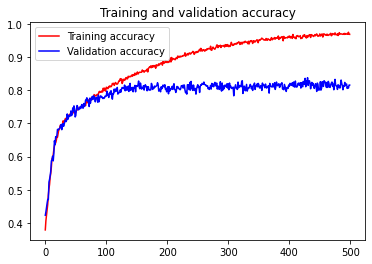

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

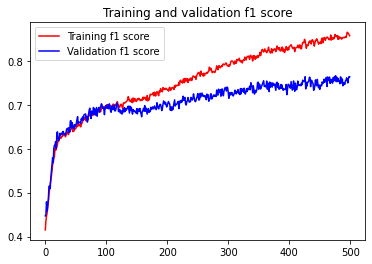

<Figure size 432x288 with 0 Axes>

In [30]:
import matplotlib.pyplot as plt
f1 = history.history['f1_score']
val_f1 = history.history['val_f1_score']

epochs = range(len(f1))

plt.plot(epochs, f1, 'r', label='Training f1 score')
plt.plot(epochs, val_f1, 'b', label='Validation f1 score')
plt.title('Training and validation f1 score')
plt.legend(loc=0)
plt.figure()


plt.show()

In [37]:
print('Test loss:', loss)
print('Test accuracy:', accuracy)
print('Test F1 score', f1_score)

Test accuracy: 0.7739657163619995
Test F1 score 0.7374783158302307


In [32]:
print('Max validation accuracy:', max(history.history['val_accuracy']))

Max validation accuracy: 0.8373737335205078


In [33]:
print('Max training accuracy:', max(history.history['accuracy']))

Max training accuracy: 0.974226176738739


In [34]:
print('Max validation F1 score:', max(history.history['val_f1_score']))

Max validation F1 score: 0.766011655330658


In [35]:
print('Max training F1 score:', max(history.history['f1_score']))

Max training F1 score: 0.8649281859397888
